# Fixed Charge Network Flow

Given a directed graph with a set of vertices $V$ and arcs $A$, a root $r\in V$, demand $b_r<0$ for the root node, and $b_v\geq 0$ for all other nodes, unit flow costs $c_{ij}$ for each arc $(ij)\in A$, and fixed costs $q_{ij}$ for the use of arc $(i,j)\in A$, the problem is to find feasible flow that minimizes the sum of all the flows and fixed costs.
Let $y_{ij}$ be the flow on arc $(ij)$ and $x_{ij}$ be equal to $1$ if arc $(i,j)$ is used.  Let $V^+(i)=\{j:(i,j)\in A\}$, $V^-(i)=\{j:(j,i)\in A\}$.The FCNFP can be formulated as follows

$$
\begin{align*}
      \min & \sum_{(i,j)\in A}c_{ij}y_{ij}+q_{ij}x_{ij}\\
           &\sum_{j\in V^-(i)}y_{ji} - \sum_{j\in V^+(i)}y_{ij} = b_i& i\in V\\
           &y_{ij}\leq |b_r| x_{ij} & (i,j)\in A\\
           &y_{ij}\geq 0, x_{ij}\in \{0,1\}& (i,j)\in A
    \end{align*}
$$

## Data
The `FCNFP` class below builds random instances of the problem. The constructor takes as input the number of nodes (an integer) and a seed (an integer) and builds at random the data of the problem.
The seed is used to control the randomness: the same seed will generate the same random instance.

## Task
Design a solution method for the problem. The solution method may be exact or heuristic (you may as well design both).
Set up expertiments with the scope of showing, empirically, how your method(s) compares to Gurobi for different sizes of the problem (i.e., number of nodes).
When you perform the experiments, give both Gurobi and your method a time limit, so that it stops after `X` minutes and delivers the best available solution.
Thus, your experiments should answer this question: *Which method delivers the best solutions within `X` minutes?*


### By Anders G. Kristensen (tzk942) and Karl P. Nørgaard (cth443)

## Code

# 0: Initiation

### 0.1: Data

In [ ]:
!pip install gurobipy

In [ ]:
# Insert Gurobi license details here:
params = {
"WLSACCESSID": "",
"WLSSECRET":"",
"LICENSEID":
}
import random as r
import gurobipy as gp
from gurobipy import GRB, quicksum, Model
import matplotlib.pyplot as plt
import numpy as np
import time as t
import networkx as nx
import seaborn as sns

env = gp.Env(params=params)

In [2]:
class FCNFP:
    '''
    This class represents the blueprint for instances of the Fixed Charge Network Flow Problem.
    The constructor generates random instances for of a given size. We also need to pass a seed which
    initializes the random number generator. Each value of the seed corresponds to a different instance of the problem.
    '''
    def __init__(self,n_nodes:int, seed:int):
        r.seed(seed)
        self.nodes = [i+1 for i in range(n_nodes)]
        self.arcs = [(i,j) for i in self.nodes for j in self.nodes if (i != 0) and (r.random() > 0.3)]
        self.flow_cost = {(i,j): 20 + 20 * r.random() for (i,j) in self.arcs}
        self.fixed_cost = {(i,j): 200 + 200 * r.random() for (i,j) in self.arcs}
        # We arbitrarilyy designate node 1 as the root
        self.demand = {i: int(50)+ r.randint(0,25) for i in self.nodes if i > 1}
        self.demand[1] = -sum(self.demand.values())

        # Create graph
        self.G = nx.DiGraph()
        for (i, j) in self.arcs:
            self.G.add_edge(i, j, flow_cost=self.flow_cost[(i, j)])

    #Reducing data by discarding arcs that can be immediately ruled out of any optimal solution

    def reduce_data(self):
        self.nodes_connected_to_root = {j for (i, j) in self.arcs if i == 1}
        self.nodes_connected_to_root_with_lowcost = {j for (i, j) in self.arcs if i == 1 and self.flow_cost[(i, j)] <= 36}

        self.nodes_not_connected_to_root = [i for i in self.nodes if i not in self.nodes_connected_to_root and i > 1]


        # Combine conditions to reduce arcs in one go
        self.arcs = [
        (i, j) for (i, j) in self.arcs if
        (i == 1 and j != 1) or
        (i != 1 and j != 1 and i != j and j not in self.nodes_connected_to_root_with_lowcost)
        ]

        self.arcs = [
        (i,j) for (i,j) in self.arcs if not (j in self.nodes_connected_to_root and i not in self.nodes_connected_to_root)
        or i==1]

        arcs_to_remove = []



        for i in list(self.nodes_connected_to_root)[1:]:
            for j in self.nodes_connected_to_root:
                if (i, j) in self.arcs:
                    # Calculate the sum of the flow costs
                    cost_sum = self.flow_cost[(1, i)] + self.flow_cost[(i, j)]

                    # Calculate the threshold
                    threshold = (self.fixed_cost[1,j] - self.fixed_cost[i,j]) / self.demand[j] + self.flow_cost[(1, j)]

                    # Check if the condition holds
                    if cost_sum > threshold:
                        arcs_to_remove.append((i, j))


        for arc in arcs_to_remove:
            self.arcs.remove(arc)


        self.nodes_only_connected_to_root = {j for j in self.nodes_connected_to_root if all(i == 1 for (i, _) in self.arcs if _ == j)}

        self.two_way_arcs = [(i,j) for (i,j) in self.arcs if (j,i) in self.arcs and i < j]

        # Efficiently filter out arcs for flow_cost and fixed_cost
        arcs_set = set(self.arcs)
        self.flow_cost = {(i, j): cost for (i, j), cost in self.flow_cost.items() if (i, j) in arcs_set}
        self.fixed_cost = {(i, j): cost for (i, j), cost in self.fixed_cost.items() if (i, j) in arcs_set}

    #Finding best paths to each terminal in naïve problem with no fixed cost
    #def compute_minimum_path_cost(self, target_node):
    #    shortest_path_length = nx.single_source_dijkstra_path_length(self.G, 1, weight='flow_cost')
    #    return shortest_path_length.get(target_node, float('inf'))
    #Computing total flow cost in naïve problem
    def compute_improved_lower_bound(self):
        improved_lower_bound = 0
        shortest_path_length = nx.single_source_dijkstra_path_length(self.G, 1, weight='flow_cost') #New
        for node in self.nodes:
            if node != 1:  # Exclude the root
                #min_path_cost = self.compute_minimum_path_cost(node)
                min_path_cost = shortest_path_length.get(node, float('inf')) #nyt
                improved_lower_bound += self.demand[node] * min_path_cost
        return improved_lower_bound

    # Constructing a first-best heuristic solution
    def heuristic_solution(self):
        activated_arcs = set()
        all_paths = nx.single_source_dijkstra_path(self.G, 1, weight='flow_cost')
        for node in self.nodes:
            if node != 1:
                path = all_paths.get(node)
                # path = nx.single_source_dijkstra_path(self.G, 1, weight='flow_cost').get(node) #Old code
                if path:
                    # Extract arcs from the path
                    for i in range(len(path) - 1):
                        activated_arcs.add((path[i], path[i+1]))

        # Compute the objective for the heuristic solution
        fixed_costs_activated = sum([self.fixed_cost[arc] for arc in activated_arcs])
        heuristic_obj = fixed_costs_activated + self.compute_improved_lower_bound()

        return heuristic_obj, activated_arcs

# 1: Solving with Gurobi's inbuilt solver

### 1.1: Constructing model for the inbuilt solver

In [3]:
class FCNFPSolver:
    def __init__(self, problem_instance):
        self.p = problem_instance
        self.m = gp.Model(env = env, name = "FCNFP")
        self.x = None
        self.y = None
        self.runtime = None


    def build_model(self):
        #Defining variables, objective and constraints
        self.x = self.m.addVars(self.p.arcs, vtype=GRB.BINARY, name="x")
        self.y = self.m.addVars(self.p.arcs, vtype=GRB.CONTINUOUS, lb=0, name="y")

        self.m.setObjective(gp.quicksum(self.p.flow_cost[i, j] * self.y[i, j] + self.p.fixed_cost[i, j] * self.x[i, j] for i, j in self.p.arcs), GRB.MINIMIZE)

        for i in self.p.nodes:
            self.m.addConstr(gp.quicksum(self.y[j, i] for j in self.p.nodes if (j, i) in self.p.arcs) -
                             gp.quicksum(self.y[i, j] for j in self.p.nodes if (i, j) in self.p.arcs) == self.p.demand[i], name = f"flow_conservation_{i}")

        self.m.addConstrs((self.y[i, j] <= abs(self.p.demand[1]) * self.x[i, j] for i, j in self.p.arcs), name="flow_bounds")

    #Defining solver w. timelimit
    def solve(self, time_limit_minutes = 2):
        self.m.Params.OutputFlag = 0
        self.m.Params.TimeLimit = 60 * time_limit_minutes
        self.m.optimize()
        self.runtime = self.m.Runtime

    #Retrieving arc_results if optimality is reached
    def print_arc_results(self):
        if self.m.status == GRB.OPTIMAL or self.m.status == GRB.SUBOPTIMAL:
            for i, j in self.p.arcs:
                x_value = self.x[i, j].X
                y_value = self.y[i, j].X
                print(f"Arc ({i}, {j}): x = {x_value}, y = {y_value}")
        else:
            print(f"No solution found. Gurobi status code: {self.m.status}")

    #Retrieving optimal solution if one is found before time limit is reached
    def get_objective_value(self):
        if self.m.status == GRB.OPTIMAL or self.m.status == GRB.SUBOPTIMAL:
            obj_value = self.m.ObjVal
            return obj_value
        else:
            print(f"No solution found. Gurobi status code: {self.m.status}")

    #Getting runtime (solving the model only)
    def get_runtime(self):
        if self.runtime is None:
            print("The model has not been solved yet.")
            return None
        return self.runtime


### 1.2: Example of using the solver

In [4]:
# Defining problem instance, getting total runtime and showing objective value
p = FCNFP(150, 1)
t1  = t.time()
solver = FCNFPSolver(p)
solver.build_model()
solver.solve()
print(solver.get_runtime())
t2 = t.time()
print('total runtime is ' +str(t2-t1))
print(solver.get_objective_value())

2.2986838817596436
total runtime is 11.69937014579773
356883.130832502


# 2: Solving with Bender's Decomposition

### 2.1 Feasibility subproblem

In [5]:
class FCNFP_FSP:
    def __init__(self, problem_instance:FCNFP, x:dict):

        self.p=problem_instance
        self.m = Model(env = env)

         # Variables
        self.y = self.m.addVars([(i,j) for (i,j) in self.p.arcs],
                                lb= 0, ub= GRB.INFINITY,name="y")

        self.v1 = self.m.addVars([(i,j) for (i,j) in self.p.arcs],
                                lb= 0, ub= GRB.INFINITY,name="v1")

        self.v2 = self.m.addVars([(i,j) for (i,j) in self.p.arcs],
                                lb= 0, ub= GRB.INFINITY,name="v2")
         # Objective
        expr = self.v1.sum() + self.v2.sum()

        self.m.setObjective(expr, GRB.MINIMIZE)

        #constraints
        self.demand_constraint=self.m.addConstrs(-self.y.sum(i,'*') + self.y.sum('*',i) +
                                                 self.v1.sum('*',i) - self.v2.sum(i,'*') == self.p.demand[i]
                                                 for i in self.p.nodes if i > 1)

        self.flow_constraint=self.m.addConstrs(self.y[i,j] <= abs(self.p.demand[1])*x[(i,j)]+self.v2[i,j]
                                               for (i,j) in self.p.arcs)

    def solve(self):
        # Solve the feasibility subproblem
        self.m.Params.OutputFlag = 0
        self.m.optimize()
    #getting results
    def getResults(self):

        dualsDC=[self.demand_constraint[i].Pi for i in self.p.nodes if i>1]
        dualsFC = { (i, j): self.flow_constraint[i, j].Pi for (i, j) in self.p.arcs }

        return self.m.objVal, dualsDC, dualsFC



### 2.2: Optimality Subproblem

In [6]:
class FCNFP_OSP:
    def __init__(self,problem_instance:FCNFP,x:dict):
        self.p = problem_instance
        self.x = x
        self.m = Model(env = env)

        # Variables
        self.y = self.m.addVars([(i,j) for (i,j) in self.p.arcs],
                                lb= 0, ub= GRB.INFINITY,name="y")

        # Objective
        expr =quicksum([self.p.flow_cost[i,j]*self.y[i,j] for (i,j) in self.p.arcs])
        self.m.setObjective(expr, GRB.MINIMIZE)


        # Constraints

        self.demand_constraint=self.m.addConstrs(-self.y.sum(i,'*') + self.y.sum('*',i) == self.p.demand[i]
                                                for i in self.p.nodes if i > 1)

        self.flow_constraint=self.m.addConstrs(self.y[i,j] <= abs(self.p.demand[1])*x[(i,j)] for (i,j) in self.p.arcs)

        #solving

    def solve(self):
        self.m.Params.OutputFlag = 0
        self.m.optimize()
        #getting results
    def getResults(self):

        dualsDC=[self.demand_constraint[i].Pi for i in self.p.nodes if i>1]
        dualsFC = { (i, j): self.flow_constraint[i, j].Pi for (i, j) in self.p.arcs }

        return self.m.objVal, dualsDC, dualsFC

### 2.3: Master Problem

In [7]:
class Master:
    def __init__(self, problem_instance:FCNFP, threshold:float):
        self.p=problem_instance
        self.phi = None
        self.x = None
        self.m = Model(env = env)
        self.threshold=threshold

    def build_model(self):
       #variables
        self.phi = self.m.addVar(vtype = GRB.CONTINUOUS, name = 'phi')
        self.x = self.m.addVars(self.p.arcs, vtype = GRB.BINARY, name = 'x')

        # Making sure variables are visible in callback
        self.m._x = self.x
        self.m._phi = self.phi

        #setting objective
        expr = self.phi + quicksum([self.p.fixed_cost[i,j] * self.x[i,j] for (i,j) in self.p.arcs])

        self.m.setObjective(expr, GRB.MINIMIZE)

        #guiding solver by adding logical constraints

        #sufficiently cheap arcs from root nodes must be used
        for (_, j) in [(i, j) for (i, j) in self.p.arcs if i == 1 and self.p.flow_cost[i,j] <= 36]:
            self.m.addConstr(self.x[1,j] == 1)

        #adding minimal flow cost to satidfy demand as lower bound on phi
        proposed_bound = self.p.compute_improved_lower_bound()
        self.m.addConstr(self.phi>=proposed_bound)

        #Exactly one arc should be used to access all nodes apart from root
        for i in self.p.nodes[1:]:
            entering_arcs_sum = quicksum(self.x[(k, i)] for k in self.p.nodes if (k, i) in self.p.arcs)
            self.m.addConstr(entering_arcs_sum == 1)
        #Should always use exactly one less arc than there are nodes
        self.m.addConstr(quicksum(self.x[(i,j)] for (i,j) in self.p.arcs) == len(self.p.nodes) - 1)
        #At most one arc connecting two nodes should be active
        for (i,j) in self.p.two_way_arcs:
            self.m.addConstr(self.x[i,j] + self.x[j,i] <= 1)
    #solving the model
    def solve(self):
        #starting timer
        t1=t.time()
        def callback(model, where):


            if where == GRB.Callback.MIPSOL:

                x_val = model.cbGetSolution(model._x)
                phi_val = model.cbGetSolution(model._phi)
                if abs(t.time()-t1)>self.threshold:
                    #stopping if time limit is reached
                    print('out of time')
                    model.terminate()

                # solving feasibility subproblem
                fsp = FCNFP_FSP(self.p, x_val)
                fsp.solve()
                obj, dualsDC, dualsFC = fsp.getResults()
                # checking feasibility, adding cut if required
                if obj > 0:
                    constr = quicksum([dualsDC[(t-2)] * self.p.demand[t]
                      for t in self.p.nodes if t > 1]) + quicksum([dualsFC[i, j] * model._x[i, j]*abs(self.p.demand[1]) for (i, j) in self.p.arcs])
                    model.cbLazy(constr<=0)

                else:
                    # solving optimality subproblem
                    osp = FCNFP_OSP(self.p, x_val)
                    osp.solve()

                    obj, dualsDC, dualsFC = osp.getResults()

                    # Checking for optimality
                    if phi_val >= obj:
                        print("Optimal solution found")
                    #Adding cut if required
                    else:
                        bound = model._phi
                        constr = quicksum([dualsDC[(t-2)] * self.p.demand[t] for t in self.p.nodes if t > 1]) + quicksum([dualsFC[i, j] * model._x[i, j]*abs(self.p.demand[1]) for (i, j) in self.p.arcs])
                        model.cbLazy(bound >= constr)

        #making sure to add lazy constraint
        self.m.setParam(GRB.Param.OutputFlag, 0)
        self.m.setParam(GRB.Param.LazyConstraints, 1)

        self.m.optimize(callback)
    #printing solution
    def print_solution(self):
        print('objective value is ' +str(self.m.objVal))
    #printing arcs for solution if one is found
    def print_arc_results(self):
        if self.m.status == GRB.OPTIMAL or self.m.status == GRB.SUBOPTIMAL:
            for i, j in self.p.arcs:
                x_value = self.x[i, j].X
                print(f"Arc ({i}, {j}): x = {x_value}")
        else:
            print(f"No solution found. Gurobi status code: {self.m.status}")
    def get_solution(self, gurobi = True):
        if gurobi:
            return self.m.objVal
        if not gurobi:
            obj_val = self.phi.X
            for (i, j) in self.p.arcs:
                obj_val += self.p.fixed_cost[i, j] * self.x[i, j].X
            return obj_val



### 2.4: Example of using Benders

In [8]:
p = FCNFP(n_nodes = 10, seed = 1)
p.reduce_data()
example=Master(p,threshold=30)
example.build_model()
example.solve()
example.print_solution()
solver = FCNFPSolver(p)
solver.build_model()
solver.solve()
print("Solver:")
print(solver.get_objective_value())
print("Benders")
print(example.get_solution(gurobi = False))


Optimal solution found
Optimal solution found
Optimal solution found
objective value is 22396.574081704086
Solver:
22396.57408170408
Benders
22396.574081704086


# 4: Plots & Graphs (to be split)

## 4.1 Illustration of lower bound on phi

In [32]:
# Experiment showing the quality of the lower bound on phi
n_values = [15, 30, 50, 75, 100, 125, 150]
n_simulations = 50

# Store results for each method
results = {
    'proposed': {'median': [], 'worst': [], 'best': []},
    'trivial': {'median': [], 'worst': [], 'best': []},
    'strengthened': {'median': [], 'worst': [], 'best': []}
}

for n in n_values:
    print(f"Processing for n = {n} ...")

    # Store gaps for current n for each method
    gaps = {'proposed': [], 'trivial': [], 'strengthened': []}

    for _ in range(n_simulations):
        # Create problem instance
        t1 = t.time()
        p_instance = FCNFP(n, t1)
        p_instance.reduce_data()
        # Compute lower bounds
        lb_proposed = p_instance.compute_improved_lower_bound()
        lb_trivial = -p_instance.demand[1] * min(p_instance.flow_cost.values())

        direct_flow_costs1 = [p_instance.flow_cost[(1, j)] for j in p_instance.nodes_connected_to_root if j > 1]

        if p_instance.nodes_not_connected_to_root:
            direct_flow_costs2 = [p_instance.flow_cost[(i, j)] for i in p_instance.nodes_connected_to_root
                                  for j in p_instance.nodes_not_connected_to_root if (i, j) in p_instance.arcs]
        else:
            direct_flow_costs2 = [0]

        lb_strengthened = -min(direct_flow_costs1) * p_instance.demand[1] + min(direct_flow_costs2) * sum(p_instance.demand[j] for j in p_instance.nodes_not_connected_to_root)

        # Solve the problem
        solver = FCNFPSolver(p_instance)
        solver.build_model()
        solver.solve()

        # Get the objective value
        obj_val = solver.get_objective_value()

        if obj_val is not None:
            gaps['proposed'].append(lb_proposed / obj_val)
            gaps['trivial'].append(lb_trivial / obj_val)
            gaps['strengthened'].append(lb_strengthened / obj_val)

    for method, values in gaps.items():
        results[method]['median'].append(np.median(values))
        results[method]['worst'].append(max(values))
        results[method]['best'].append(min(values))

Processing for n = 15 ...
Processing for n = 30 ...
Processing for n = 50 ...
Processing for n = 75 ...
Processing for n = 100 ...
Processing for n = 125 ...
Processing for n = 150 ...


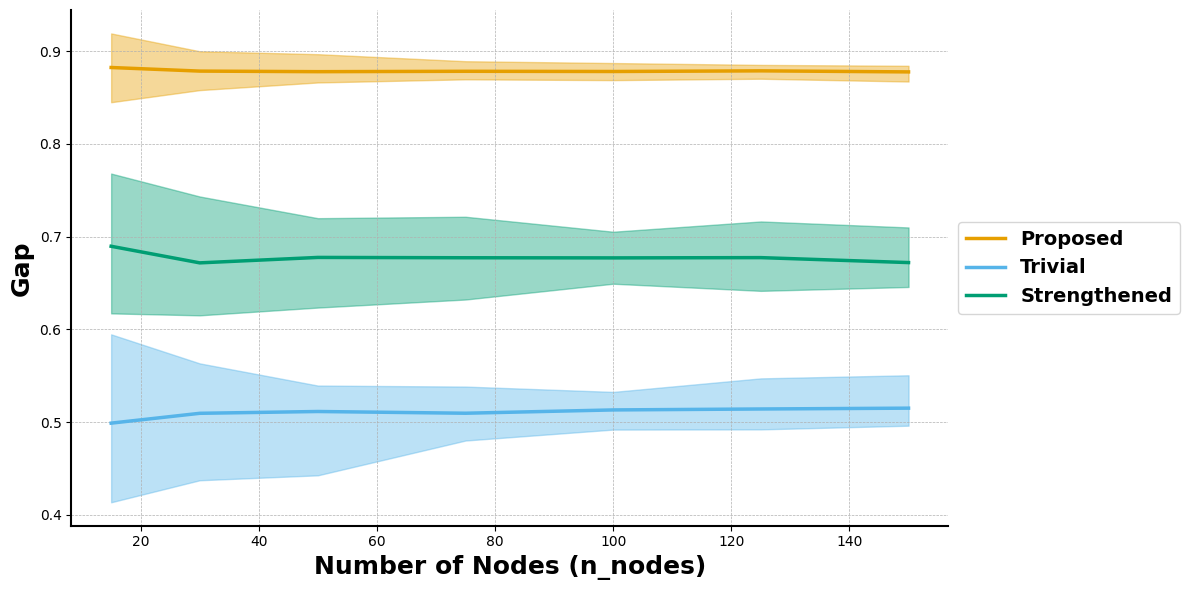

In [33]:
plt.figure(figsize=(12, 6))

# Colorblind-friendly palette
colors = {'proposed': '#E69F00', 'trivial': '#56B4E9', 'strengthened': '#009E73'}

for method, color in colors.items():
    # Ribbon around the median
    plt.fill_between(n_values, results[method]['best'], results[method]['worst'], color=color, alpha=0.4)

    # Plotting lines for median with thicker line
    plt.plot(n_values, results[method]['median'], linestyle='-', color=color, label=f'{method.capitalize()}', linewidth=2.5)

# Title and labels
#plt.title("Gap Between Lower Bound and Objective Value", fontsize=18, fontweight='bold')
plt.xlabel("Number of Nodes (n_nodes)", fontweight='bold', fontsize=18)
plt.ylabel("Gap", fontweight='bold', fontsize=18)

# Bold legend labels
legend = plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize = 14)
for text in legend.get_texts():
    text.set_fontweight('bold')

# Grid style and axis width
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)

plt.tight_layout()
plt.show()

In [34]:
# Comparison of computation times:
methods = ['trivial', 'strengthened', 'proposed']
computation_times = {method: {'median': [], 'best': [], 'worst': []} for method in methods}

for n in n_values:
    print(f"Processing n = {n}")
    times_for_current_n = {method: [] for method in methods}

    for _ in range(n_simulations):
        p_instance = FCNFP(n, t.time())
        p_instance.reduce_data()
        # Trivial method
        start_time = t.time()
        trivial_lower_bound = p_instance.demand[1] * min(p_instance.flow_cost.values())
        elapsed_time = t.time() - start_time
        times_for_current_n['trivial'].append(elapsed_time)

        # Strengthened method
        start_time = t.time()
        direct_flow_costs1 = [p_instance.flow_cost[(1, j)] for j in p_instance.nodes_connected_to_root if j > 1]
        if p_instance.nodes_not_connected_to_root:
            direct_flow_costs2 = [p_instance.flow_cost[(i, j)] for i in p_instance.nodes_connected_to_root
                                  for j in p_instance.nodes_not_connected_to_root if (i,j) in p_instance.arcs]
        else:
            direct_flow_costs2 = [0]
        strengthened_bound2 = -min(direct_flow_costs1) * p_instance.demand[1] + min(direct_flow_costs2) * sum(p_instance.demand[j] for j in p_instance.nodes_not_connected_to_root)
        elapsed_time = t.time() - start_time
        times_for_current_n['strengthened'].append(elapsed_time)

        # Proposed method
        start_time = t.time()
        proposed_lower_bound = p_instance.compute_improved_lower_bound()
        elapsed_time = t.time() - start_time
        times_for_current_n['proposed'].append(elapsed_time)

    for method in methods:
        avg_time = np.median(times_for_current_n[method])
        worst_time = max(times_for_current_n[method])
        best_time = min(times_for_current_n[method])

        computation_times[method]['median'].append(avg_time)
        computation_times[method]['worst'].append(worst_time)
        computation_times[method]['best'].append(best_time)


Processing n = 15
Processing n = 30
Processing n = 50
Processing n = 75
Processing n = 100
Processing n = 125
Processing n = 150


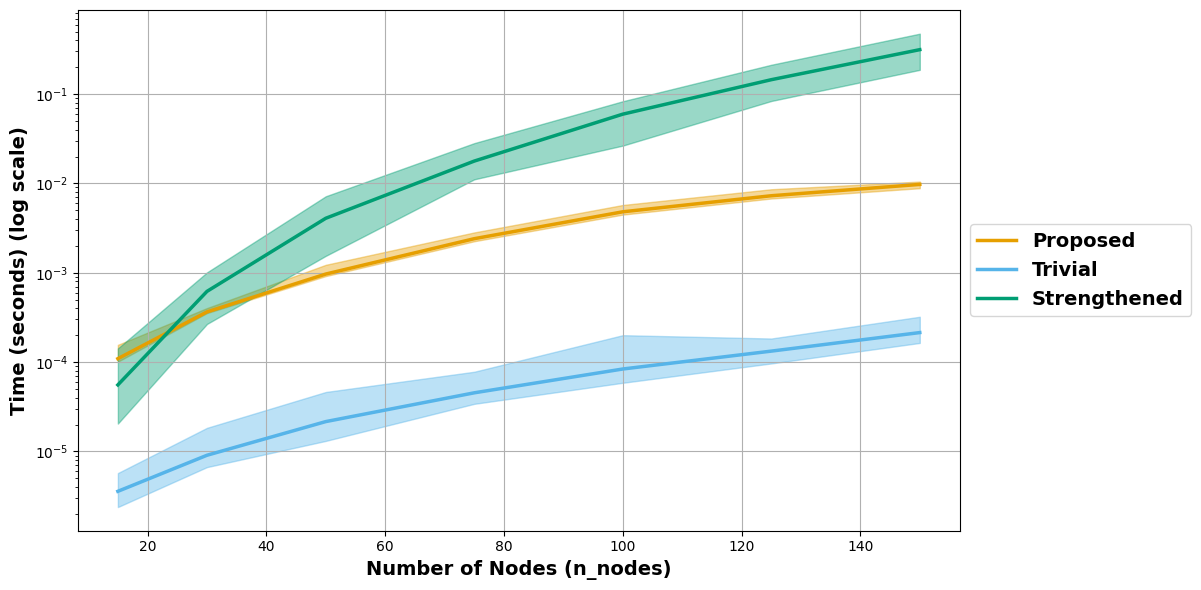

In [35]:
plt.figure(figsize=(12, 6))
colors = {'proposed': '#E69F00', 'trivial': '#56B4E9', 'strengthened': '#009E73'}

for method, color in colors.items():
    # Ribbon around the median
    plt.fill_between(n_values, computation_times[method]['best'], computation_times[method]['worst'], color=color, alpha=0.4)
    # Plotting lines for median with thicker line
    plt.plot(n_values, computation_times[method]['median'], linestyle='-', color=color, label=f'{method.capitalize()}', linewidth=2.5)

plt.xlabel("Number of Nodes (n_nodes)", fontweight='bold', fontsize=14)
plt.ylabel("Time (seconds) (log scale)", fontweight='bold', fontsize=14)  # Updated y-axis label
plt.grid(True)
legend = plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=14)
for text in legend.get_texts():
    text.set_fontweight('bold')
plt.tight_layout()
plt.yscale("log")
plt.show()

# 4.2 Heuristic vs Gurobi

In [26]:
# Experiment Parameters
n_values = [10, 20, 30, 50, 75, 100, 125, 175, 225, 275, 300]
repeats = 20

overall_results = {
    'runtime_ratio': {'worst': [], 'median': [], 'best': []},
    'objective_ratio': {'worst': [], 'median': [], 'best': []},
    'solver_runtimes': {'worst': [], 'median': [], 'best': []},
    'heuristic_runtimes': {'worst': [], 'median': [], 'best': []}
}

for n in n_values:
    print(f'Grinding... {n}')
    runtime_ratios = []
    objective_ratios = []
    solver_runtimes_list = []
    heuristic_runtimes_list = []

    for i in range(repeats):
        if ((i+1) % 5 == 0 or (i+1) == 1) and n >= 100:
            print(f'currently at: {i+1}')
        p = FCNFP(n, t.time())
        p.reduce_data()

        # Solver
        t1 = t.time()
        solver = FCNFPSolver(p)
        solver.build_model()
        solver.solve()
        solver_objective_val = solver.get_objective_value()
        t2 = t.time()
        solver_runtime = t2-t1

        # Heuristic
        t3 = t.time()
        heuristic_val, _ = p.heuristic_solution()
        t4 = t.time()
        heuristic_runtime = t4-t3

        # Compute ratios and store absolute runtimes
        runtime_ratios.append(solver_runtime/heuristic_runtime)
        objective_ratios.append(heuristic_val/solver_objective_val)
        solver_runtimes_list.append(solver_runtime)
        heuristic_runtimes_list.append(heuristic_runtime)

    # Store results
    overall_results['runtime_ratio']['worst'].append(max(runtime_ratios))
    overall_results['runtime_ratio']['median'].append(np.median(runtime_ratios))
    overall_results['runtime_ratio']['best'].append(min(runtime_ratios))

    overall_results['objective_ratio']['worst'].append(max(objective_ratios))
    overall_results['objective_ratio']['median'].append(np.median(objective_ratios))
    overall_results['objective_ratio']['best'].append(min(objective_ratios))

    overall_results['solver_runtimes']['worst'].append(max(solver_runtimes_list))
    overall_results['solver_runtimes']['median'].append(np.median(solver_runtimes_list))
    overall_results['solver_runtimes']['best'].append(min(solver_runtimes_list))

    overall_results['heuristic_runtimes']['worst'].append(max(heuristic_runtimes_list))
    overall_results['heuristic_runtimes']['median'].append(np.median(heuristic_runtimes_list))
    overall_results['heuristic_runtimes']['best'].append(min(heuristic_runtimes_list))
print("Done")

Grinding... 10
Grinding... 20
Grinding... 30
Grinding... 50
Grinding... 75
Grinding... 100
currently at: 1
currently at: 5
currently at: 10
currently at: 15
currently at: 20
Grinding... 125
currently at: 1
currently at: 5
currently at: 10
currently at: 15
currently at: 20
Grinding... 175
currently at: 1
currently at: 5
currently at: 10
currently at: 15
currently at: 20
Grinding... 225
currently at: 1
currently at: 5
currently at: 10
currently at: 15
currently at: 20
Grinding... 275
currently at: 1
currently at: 5
currently at: 10
currently at: 15
currently at: 20
Grinding... 300
currently at: 1
currently at: 5
currently at: 10
currently at: 15
currently at: 20
Done


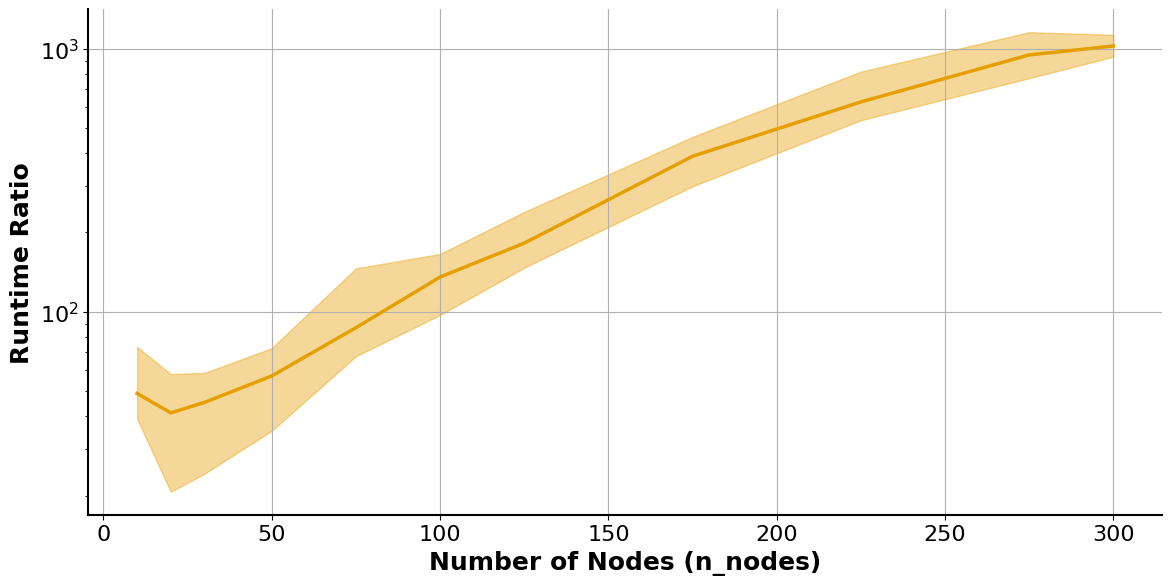

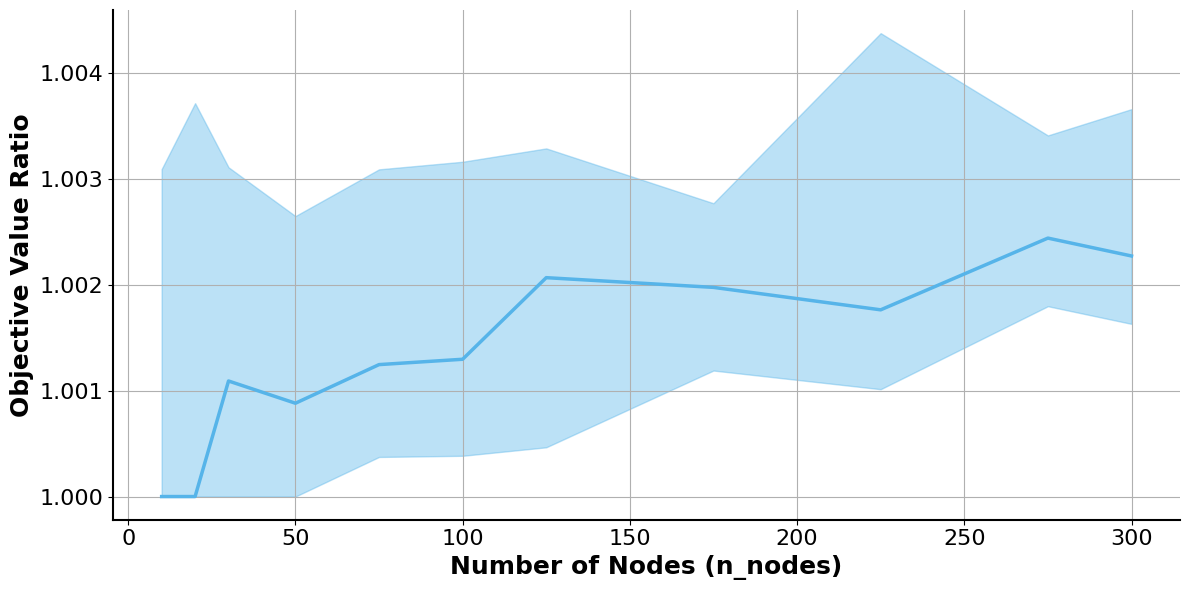

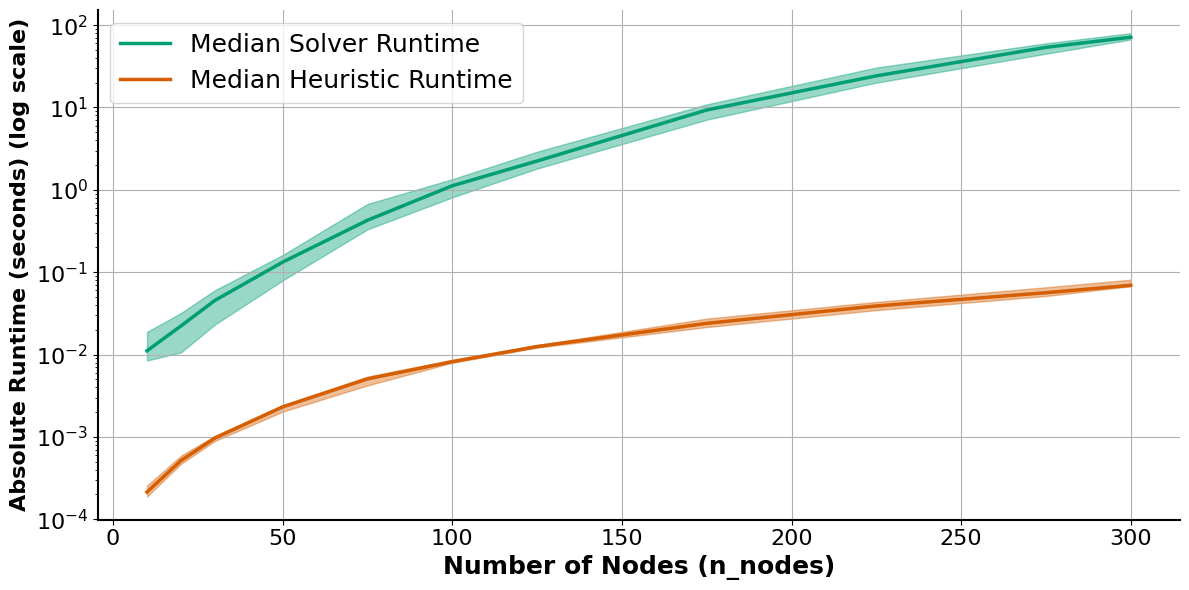

In [31]:
# Plotting Runtime Ratios
plt.figure(figsize=(12, 6))

method = 'runtime_ratio'
color = '#E69F00'

plt.fill_between(n_values, overall_results[method]['best'], overall_results[method]['worst'], color=color, alpha=0.4)
plt.plot(n_values, overall_results[method]['median'], linestyle='-', color=color, label=f'Median Runtime Ratio', linewidth=2.5)

plt.xlabel("Number of Nodes (n_nodes)", fontweight='bold', fontsize=18)
plt.ylabel("Runtime Ratio", fontweight='bold', fontsize=18)

plt.grid(True)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.yscale("log")
plt.show()

plt.figure(figsize=(12, 6))

method = 'objective_ratio'
color = '#56B4E9'

plt.fill_between(n_values, overall_results[method]['best'], overall_results[method]['worst'], color=color, alpha=0.4)
plt.plot(n_values, overall_results[method]['median'], linestyle='-', color=color, label=f'Median Objective Value Ratio', linewidth=2.5)

plt.xlabel("Number of Nodes (n_nodes)", fontweight='bold', fontsize=18)
plt.ylabel("Objective Value Ratio", fontweight='bold', fontsize=18)

plt.grid(True)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))


plt.fill_between(n_values, overall_results['solver_runtimes']['best'], overall_results['solver_runtimes']['worst'], color='#009E73', alpha=0.4)
plt.plot(n_values, overall_results['solver_runtimes']['median'], linestyle='-', color='#009E73', label=f'Median Solver Runtime', linewidth=2.5)

plt.fill_between(n_values, overall_results['heuristic_runtimes']['best'], overall_results['heuristic_runtimes']['worst'], color='#D55E00', alpha=0.4)
plt.plot(n_values, overall_results['heuristic_runtimes']['median'], linestyle='-', color='#D55E00', label=f'Median Heuristic Runtime', linewidth=2.5)

plt.xlabel("Number of Nodes (n_nodes)", fontweight='bold', fontsize=18)
plt.ylabel("Absolute Runtime (seconds) (log scale)", fontweight='bold', fontsize=16)

plt.legend(loc="upper left", fontsize = 18)
plt.grid(True)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.yscale("log")
plt.tight_layout()
plt.show()

# 4.3. Bender vs Gurobi

In [ ]:
def run_benders_vs_gurobi(n_instances=10, n_nodes_list=[10], max_time_minutes=2):
    results = {'benders_obj': [], 'solver_obj': [], 'benders_runtime': [], 'solver_runtime': []}

    for n_nodes in n_nodes_list:
      print(f'Grinding... {n_nodes}')
      for i in range(n_instances):
            if i+1 == 1 or (i+1) % 5 == 0:
              print(f'Currently working on: {i+1}')


            seed = int(t.time())
            p = FCNFP(n_nodes, seed)
            p.reduce_data()


            benders = Master(p, threshold=120)
            benders.build_model()
            benders_start_time = t.time()
            benders.solve()
            benders_runtime = t.time() - benders_start_time
            benders_obj = benders.get_solution(gurobi=False)


            solver = FCNFPSolver(p)
            solver_start_time = t.time()
            solver.build_model()
            solver.solve(time_limit_minutes=max_time_minutes)
            solver_obj = solver.get_objective_value()
            solver_runtime  = t.time() - solver_start_time


            results['benders_obj'].append(benders_obj)
            results['solver_obj'].append(solver_obj)
            results['benders_runtime'].append(benders_runtime)
            results['solver_runtime'].append(solver_runtime)

    return results, n_nodes_list

def process_results(results, n_nodes_list):
    data = {
        'obj_ratio': {
            'best': [],
            'median': [],
            'worst': []
        },
        'runtime_benders': {
            'best': [],
            'median': [],
            'worst': []
        },
        'runtime_gurobi': {
            'best': [],
            'median': [],
            'worst': []
        }
    }

    n_instances = len(results['benders_obj']) // len(n_nodes_list)

    for i in range(0, len(n_nodes_list)):
        ratios = [b/s for b, s in zip(results['benders_obj'][i*n_instances:(i+1)*n_instances], results['solver_obj'][i*n_instances:(i+1)*n_instances])]
        runtimes_benders = results['benders_runtime'][i*n_instances:(i+1)*n_instances]
        runtimes_gurobi = results['solver_runtime'][i*n_instances:(i+1)*n_instances]

        data['obj_ratio']['best'].append(min(ratios))
        data['obj_ratio']['median'].append(np.median(ratios))
        data['obj_ratio']['worst'].append(max(ratios))

        data['runtime_benders']['best'].append(min(runtimes_benders))
        data['runtime_benders']['median'].append(np.median(runtimes_benders))
        data['runtime_benders']['worst'].append(max(runtimes_benders))

        data['runtime_gurobi']['best'].append(min(runtimes_gurobi))
        data['runtime_gurobi']['median'].append(np.median(runtimes_gurobi))
        data['runtime_gurobi']['worst'].append(max(runtimes_gurobi))

    return data

n_nodes_range = [10, 20, 30, 50, 75, 100, 150]
results, n_nodes_list = run_benders_vs_gurobi(n_instances=10, n_nodes_list=n_nodes_range)


data = process_results(results, n_nodes_list)

# Plot the results
plt.figure(figsize=(14, 6))


plt.subplot(1, 2, 1)
plt.fill_between(n_nodes_list, data['obj_ratio']['best'], data['obj_ratio']['worst'], color='#E69F00', alpha=0.4)
plt.plot(n_nodes_list, data['obj_ratio']['median'], color='#E69F00', label='Objective Ratio', linewidth=2.5)

plt.xlabel("Number of Nodes", fontsize=14, fontweight='bold')
plt.ylabel("Ratio between objectives", fontsize=14, fontweight='bold')
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


plt.subplot(1, 2, 2)
plt.fill_between(n_nodes_list, data['runtime_benders']['best'], data['runtime_benders']['worst'], color='#E69F00', alpha=0.4, label='Benders')
plt.fill_between(n_nodes_list, data['runtime_gurobi']['best'], data['runtime_gurobi']['worst'], color='#56B4E9', alpha=0.4, label='Gurobi')
plt.plot(n_nodes_list, data['runtime_benders']['median'], color='#E69F00', linewidth=2.5)
plt.plot(n_nodes_list, data['runtime_gurobi']['median'], color='#56B4E9', linewidth=2.5)

plt.xlabel("Number of Nodes", fontsize=14, fontweight='bold')
plt.ylabel("Time (seconds) (log scale)", fontsize=14, fontweight='bold')
legend = plt.legend(fontsize=14)
for text in legend.get_texts():
    text.set_fontweight('bold')
plt.grid(True)
plt.yscale("log")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

In [33]:
# Defining problem instance, getting total runtime and showing objective value
p = FCNFP(5000, 1)
print("start cleaning")
#p.reduce_data()
print("Done cleaning")
"""
t1  = t.time()
solver = FCNFPSolver(p)
solver.build_model()
solver.solve()
time_used_solver = t.time()-t1
print('total runtime is ' + str(time_used_solver))
solver_obj_val = solver.get_objective_value()
print(solver_obj_val)
"""
t2 = t.time()
obj_val, _ = p.heuristic_solution()
print(obj_val)
time_used_heuristic = t.time()-t2
print('total runtime heuristic is ' + str(time_used_heuristic))

#print('Ratio of objective is: ' + str(obj_val/solver_obj_val))

start cleaning
Done cleaning
11823209.69861175
total runtime heuristic is 16.416813135147095
